# House Price Prediction
A real estate company wants to understand the factors that impact the price of the houses in a region, and basically want to predict the house prices. Specially, they want to know:
  
- which features are significant in predicting the price of the houses in that region?
- how well those variables can predict the price of the houses in that region?
  
For this purpose, a dataset of the house prices is provided containing the price of every house along with different features of the house including surface area, location and neighbourhood, garage, utilities, etc.

The objective is to analyse the data, develop a linear regression model, if applicable at all, do a Ridge and Lasso regression, and advise the business with feedback on the above business problems.

In [1]:
# import libraries

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

In [2]:
def drop_nan_cols(df, threshold = 0.2):
    """
    This function drops the columns of the df if the number of 'NaN's of the column is beyond a limit.
    The limit (threshold) is the ratio of the number of 'NaN's to the number of rows of the df.
    """
    for col in df.columns:
        if df[col].isna().sum() / df.shape[0] >= threshold:
            df.drop(col, axis=1, inplace=True)

def age_calc(df, col, new_col, ref_year):
    """
    This function calculates the 'age' for the columns that are based on year. Then drops the orignal column.
    """
    df[new_col] = df[col].apply(lambda x: ref_year - x)
    df.drop(col, axis=1, inplace=True)
    return df

def cat_col_to_dummy(df, col):
    """
    This function creates the required dummay columns for the df corresponding to a supplied categorical column
    Adds the dummy df to the current df, and deletes the original (supplied) categorical column
    """
    dummy_df = pd.get_dummies(df[col], drop_first = True)
    df = pd.concat([df, dummy_df], axis = 1)
    df = df.drop(col, axis = 1)
    return df

In [3]:
# setting reference value(s)

ref_year = 2022.0 # reference year for calculation of age of different things

# Step 1: Importing, Understanding the Data, and EDA

In [4]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.shape

(1460, 81)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# percentage of missing values in all the columns
cols_missing_prctg = round(df.isnull().sum() / df.shape[0], 3).sort_values(ascending = False)
cols_missing_prctg[:10]

PoolQC          0.995
MiscFeature     0.963
Alley           0.938
Fence           0.808
FireplaceQu     0.473
LotFrontage     0.177
GarageYrBlt     0.055
GarageCond      0.055
GarageType      0.055
GarageFinish    0.055
dtype: float64

As can be seen, the 6 columns of: 'PoolQC', 'MiscFeature', 'Alley', 'Fence, 'FireplaceQu', and 'LotFrontage', has missing values of 99.5% to 17.7% of the rows of the column. Also, later it will be seen that the missing values in the columns: 'GarageYrBlt', 'GarageCond', 'GarageType', and 'GarageFinish', correspond to the houses without any garages. The missing values within these latter columns are dealt with later. Therefore, for now, the threshold of 10% NaN values within a column to be dropped, seems a reasonable values.

In [8]:
threshold_nan_col = 0.1 # minimum ratio of a column's 'NaN's to the number of rows of the df, to be dropped off

drop_nan_cols(df, threshold_nan_col)
df.shape

(1460, 75)

The number of columns dropped to 75 from 81 as a result of dropping the abovementioned 6 columns.  
  
#### Defining the target column for later use

In [9]:
target_col = 'SalePrice'

Dropping the 'Id' column as it is a randomly generated number and has no contribution to the target.

In [10]:
df.drop(['Id'], axis=1, inplace=True)

In [11]:
# finding percentage of missing values in the rows

rows_null_prcntg = []
for i in range(df.shape[0]):
    rows_null_prcntg.append(round(float(df.loc[i].isna().sum() / df.shape[1]), 3))

rows_null_prtg_df = pd.DataFrame(list(zip(list(df.index), rows_null_prcntg)))
rows_null_prtg_df.columns = ['df_index', 'missing_prctg']
rows_null_prtg_df.sort_values(by=['missing_prctg'], ascending = False)
rows_null_prtg_df

,df_index,missing_prctg
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
1455,1455,0.0
1456,1456,0.0
1457,1457,0.0
1458,1458,0.0


Hence, no remarkable high percentage of missing values in any row to be dropped.

In [12]:
# Now checking if there are any columns that have only one unique value, to drop those columns.

cols_1uniq_val = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        cols_1uniq_val.append(col)

print('Columns with only one unique value: ', cols_1uniq_val)

Columns with only one unique value:  []


Hence, there are no columns that have only one unique value, so to drop the whole column.  
  
  
### Dealing with the missing values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [14]:
# the column 'MasVnrType' has 8 null values. Let's drop those
df = df[~df['MasVnrType'].isnull() == True]


Next, the columns 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' and 'BsmtFinType2' have null values. Based on the data dictionary, these values correspond to a house without any basements. Hence, these null values are replaced with 'NoBsmt'.

In [15]:
df['BsmtQual'].fillna('NoBsmt', inplace = True)
df['BsmtCond'].fillna('NoBsmt', inplace = True)
df['BsmtExposure'].fillna('NoBsmt', inplace = True)
df['BsmtFinType1'].fillna('NoBsmt', inplace = True)
df['BsmtFinType2'].fillna('NoBsmt', inplace = True)

The 'Electrical' column has 1 null value. so let's drop that.

In [16]:
df = df[~df['Electrical'].isnull() == True]

Next, let's deal with the null values of 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'. Based on the data disctionary, the null values of all these columns, except the 'GarageYrBlt' column, correspond to the houses without any garages. Therefore, the null values of these columns are replaced with 'NoGarage'.  
Regarding the null values of 'GarageYrBlt', these might correspond to the houses without garage, i.e. to the null values of the garage columns above. To check this:

In [17]:
df[df['GarageFinish'].isnull() == True][['GarageFinish', 'GarageYrBlt']].isnull().sum()

GarageFinish    81
GarageYrBlt     81
dtype: int64

As can be seen and was guessed, the null values of 'GarageYrBlt' correspond to the No Garage houses. Therefore, the null values within 'GarageYrBlt' are replaced with the reference year, since later the age of the garage for these houses will be calculated as 0.

In [18]:
df['GarageYrBlt'].fillna(ref_year, inplace = True)
df['GarageType'].fillna('GrgTyp-NoGrg', inplace = True)
df['GarageFinish'].fillna('NoGrg', inplace = True)
df['GarageQual'].fillna('NoGrg', inplace = True)
df['GarageCond'].fillna('NoGrg', inplace = True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1451 non-null   int64  
 1   MSZoning       1451 non-null   object 
 2   LotArea        1451 non-null   int64  
 3   Street         1451 non-null   object 
 4   LotShape       1451 non-null   object 
 5   LandContour    1451 non-null   object 
 6   Utilities      1451 non-null   object 
 7   LotConfig      1451 non-null   object 
 8   LandSlope      1451 non-null   object 
 9   Neighborhood   1451 non-null   object 
 10  Condition1     1451 non-null   object 
 11  Condition2     1451 non-null   object 
 12  BldgType       1451 non-null   object 
 13  HouseStyle     1451 non-null   object 
 14  OverallQual    1451 non-null   int64  
 15  OverallCond    1451 non-null   int64  
 16  YearBuilt      1451 non-null   int64  
 17  YearRemodAdd   1451 non-null   int64  
 18  RoofStyl

Now, the data set has no missing values. Let's look at the statistics of the numeric columns.  
As can be seen below, there can't be identified any eye catching problems. However, the potential outliers are dealt with later.

In [20]:
df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.00000,1451.000000,1451.000000,1451.000000,...,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,56.933150,10507.808408,6.093728,5.579600,1971.092350,1984.760165,103.75672,442.274983,46.838043,567.197105,...,94.412819,46.422467,21.952447,3.430737,15.154376,2.776017,43.758787,6.319090,2007.815300,180624.101999
std,42.350366,9992.987081,1.381467,1.113415,30.190266,20.651334,181.10815,455.369276,161.777324,442.209192,...,125.436852,66.060150,61.108223,29.406940,55.917522,40.301212,497.648467,2.700353,1.329376,79312.128273
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7537.500000,5.000000,5.000000,1954.000000,1966.000000,0.00000,0.000000,0.000000,222.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,9477.000000,6.000000,5.000000,1972.000000,1993.000000,0.00000,381.000000,0.000000,479.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,70.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,166.00000,707.000000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.00000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [21]:
df.describe().columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

The column 'MSSubClass' is listed as numeric, however, it is actually categorical according to the data dictionary. Therefore, its values are mapped according to the data dictionary, below.

In [22]:
df['MSSubClass'] = df['MSSubClass'].map({20: '1-STORY 1946 & NEWER ALL STYLES',
                                           30: '1-STORY 1945 & OLDER',
                                           40: '1-STORY W/FINISHED ATTIC ALL AGES',
                                           45: '1-1/2 STORY - UNFINISHED ALL AGES',
                                           50: '1-1/2 STORY FINISHED ALL AGES',
                                           60: '2-STORY 1946 & NEWER',
                                           70: '2-STORY 1945 & OLDER',
                                           75: '2-1/2 STORY ALL AGES',
                                           80: 'SPLIT OR MULTI-LEVEL',
                                           85: 'SPLIT FOYER',
                                           90: 'DUPLEX - ALL STYLES AND AGES',
                                           120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
                                           160: '2-STORY PUD - 1946 & NEWER',
                                           180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                                           190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'})

The values of 'MoSold' are actually the months. Therefore, these are also mapped to months names, below.

In [23]:
df['MoSold'] = df['MoSold'].map({1: 'Jan',
                                  2: 'Feb',
                                  3: 'Mar',
                                  4: 'Apr',
                                  5: 'May',
                                  6: 'Jun',
                                  7: 'Jul',
                                  8: 'Aug',
                                  9: 'Sep',
                                  10: 'Oct',
                                  11: 'Nov',
                                  12: 'Dec'})

#### Calculating Age based on Year
Changing 'YearBuilt' into 'HouseAge', 'YearRemodAdd' into 'RemodAddAge', 'GarageYrBlt' into 'GarageAge', and 'YrSold' into 'SoldAge', and finally dropping the original Year columns.

In [24]:
df = age_calc(df, 'YearBuilt', 'HouseAge', ref_year)
df = age_calc(df, 'YearRemodAdd', 'RemodAddAge', ref_year)
df = age_calc(df, 'GarageYrBlt', 'GarageAge', ref_year)
df = age_calc(df, 'YrSold', 'SoldAge', ref_year)

The columns below are ordinal, meaning they are ranking/comparing the quality/condition/functionality of different attributes of the house. Therefore, the state of quality/condition/rank are assigned integer values starting from 0.

In [25]:
df['LandSlope'] = df['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':2})
df['LotShape'] = df['LotShape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3})
df['ExterQual'] = df['ExterQual'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['ExterCond'] = df['ExterCond'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['BsmtQual'] = df['BsmtQual'].map({'NoBsmt':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['BsmtCond'] = df['BsmtCond'].map({'NoBsmt':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['BsmtExposure'] = df['BsmtExposure'].map({'NoBsmt':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'NoBsmt':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'NoBsmt':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['HeatingQC'] = df['HeatingQC'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['CentralAir'] = df['CentralAir'].map({'N':0, 'Y':1})
df['KitchenQual'] = df['KitchenQual'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['Functional'] = df['Functional'].map({'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 
                                         'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7})
df['GarageFinish'] = df['GarageFinish'].map({'NoGrg':0, 'Unf':1, 'RFn':2, 'Fin':3})
df['GarageQual'] = df['GarageQual'].map({'NoGrg':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['GarageCond'] = df['GarageCond'].map({'NoGrg':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['PavedDrive'] = df['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

### Inspecting and dealing with potential outliers
For this purpose we take 25% and 90% quantiles as the InterQuantile Range (IQR).

In [26]:
IQR_upper_limit = df[target_col].quantile(.90)
IQR_lower_limit = df[target_col].quantile(.25)
IQR = IQR_upper_limit - IQR_lower_limit
outliers_upper_bound = IQR_upper_limit + 1.5 * IQR
outliers_lower_bound = IQR_lower_limit - 1.5 * IQR
print('The lower bound and upper bound for potential outliers are {} and {}, respectively.'.format(outliers_lower_bound, outliers_upper_bound))

The lower bound and upper bound for potential outliers are -92250.0 and 500150.0, respectively.


Therefore, it can be seen there is no lower outliers. Let's inspect the outliers larger than the upper bound.

In [27]:
df[df[target_col] > outliers_upper_bound]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,RemodAddAge,GarageAge,SoldAge
178,1-STORY 1946 & NEWER ALL STYLES,RL,17423,Pave,2,Lvl,AllPub,CulDSac,2,StoneBr,...,0,0,Jul,New,Partial,501837,14.0,13.0,13.0,13.0
440,1-STORY 1946 & NEWER ALL STYLES,RL,15431,Pave,3,Lvl,AllPub,Inside,2,NridgHt,...,0,0,Apr,WD,Normal,555000,14.0,14.0,14.0,13.0
691,2-STORY 1946 & NEWER,RL,21535,Pave,2,Lvl,AllPub,Corner,2,NoRidge,...,0,0,Jan,WD,Normal,755000,28.0,27.0,28.0,15.0
769,2-STORY 1946 & NEWER,RL,53504,Pave,1,HLS,AllPub,CulDSac,1,StoneBr,...,0,0,Jun,WD,Normal,538000,19.0,19.0,19.0,12.0
803,2-STORY 1946 & NEWER,RL,13891,Pave,3,Lvl,AllPub,Inside,2,NridgHt,...,0,0,Jan,New,Partial,582933,14.0,13.0,13.0,13.0
898,1-STORY 1946 & NEWER ALL STYLES,RL,12919,Pave,2,Lvl,AllPub,Inside,2,NridgHt,...,0,0,Mar,New,Partial,611657,13.0,12.0,13.0,12.0
1046,2-STORY 1946 & NEWER,RL,16056,Pave,2,Lvl,AllPub,Inside,2,StoneBr,...,0,0,Jul,New,Partial,556581,17.0,16.0,17.0,16.0
1169,2-STORY 1946 & NEWER,RL,35760,Pave,2,Lvl,AllPub,CulDSac,2,NoRidge,...,0,0,Jul,WD,Normal,625000,27.0,26.0,27.0,16.0
1182,2-STORY 1946 & NEWER,RL,15623,Pave,2,Lvl,AllPub,Corner,2,NoRidge,...,555,0,Jul,WD,Abnorml,745000,26.0,26.0,26.0,15.0


Hence, we can safely remove these 9 outliers without any impact on the analysis.

In [28]:
df = df[df[target_col] < outliers_upper_bound]
df.shape

(1442, 74)

In [29]:
# checking if there are any duplicates? No, there's no duplicates in the dataframe.

df.duplicated().sum()

0

### Brief EDA
#### Numeric columns EDA
Some of the numeric columns are selected for EDA and pair plot visualisation as below.

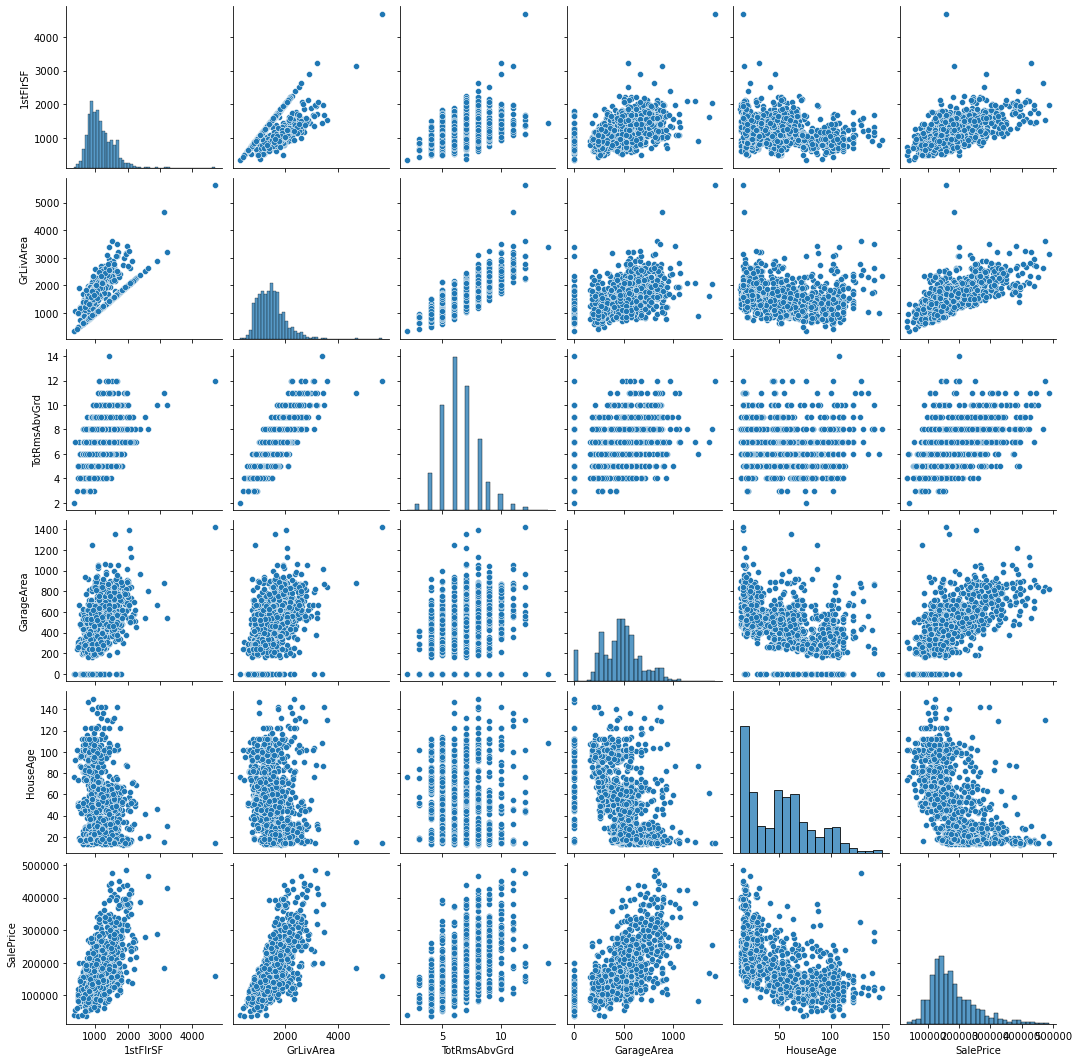

In [30]:
sel_num_cols = ['1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'HouseAge', target_col]
sns.pairplot(df[sel_num_cols])
plt.show()

As can be seen:
- There is a linear correlation between some of the numeric columns and the target column. Hence, a linear regression model can be considered and trained.
- Also, it can be observed that there are correlations between different numeric columns as well, e.g. between 'GrLivArea' and 'TotRmsAbvGrd', or between '1stFlrSF' and 'GrLivArea'. However, let's RFE decides to choose the most important features for the regression model rather than dropping the columns that have some degree of correlation between themselves.  

#### Categorical columns EDA

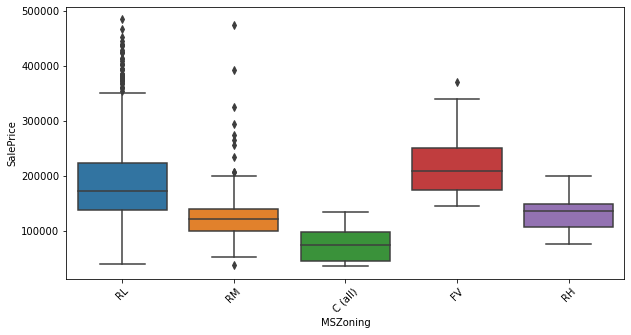

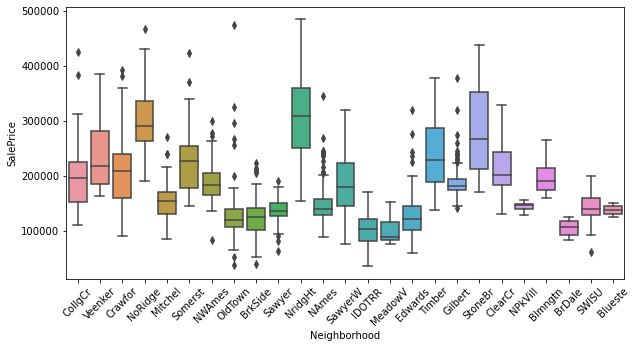

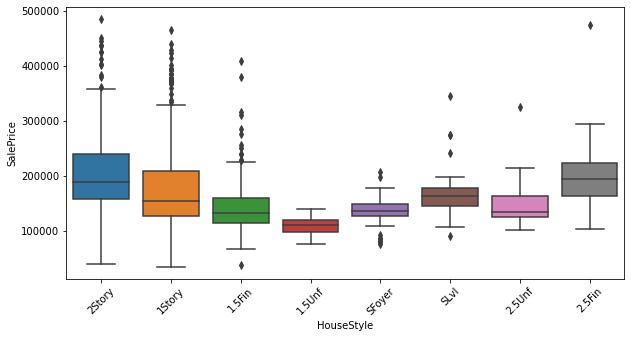

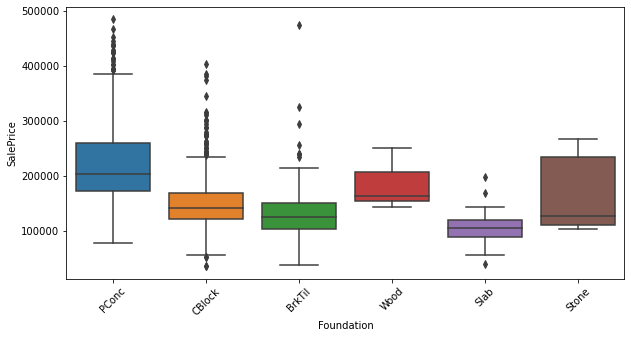

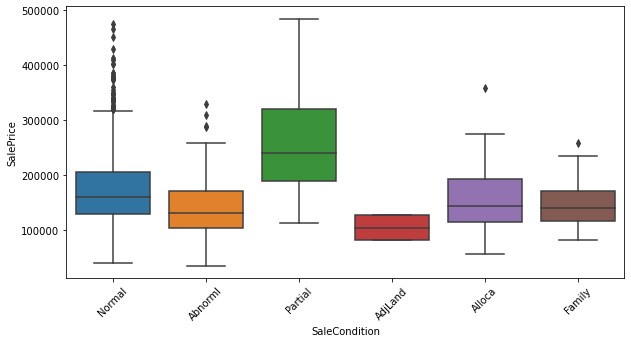

In [31]:
sel_cat_cols = ['MSZoning', 'Neighborhood', 'HouseStyle', 'Foundation', 'SaleCondition']

for col in sel_cat_cols:
    plt.figure(figsize = (10,5))
    sns.boxplot(data=df, x=col, y=target_col)
    plt.xticks(rotation=45)
    plt.show()

As can be seen, the categorical columns have contribution to the target variable since moving across different categories of each of these columns leads to changes in the range of the target variable.  
Let's look at the month of selling, i.e. 'MoSold', to see if it has a great impact on the target variable.

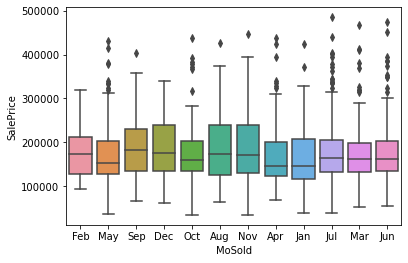

In [32]:
sns.boxplot(data=df, x='MoSold', y=target_col)
plt.show()

As can be seen, there is not much of an impact of different months of selling on the target variable. Therefore, this column, 'MoSold' is dropped.

In [33]:
df.drop('MoSold', axis=1, inplace=True)

#### Visualising the target variable 'SalePrice'

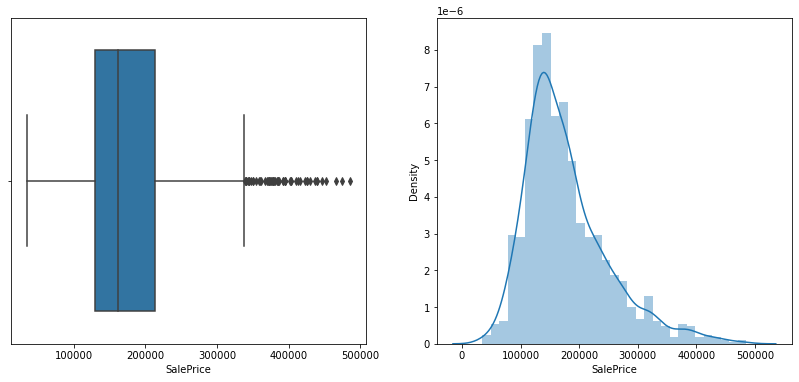

In [34]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.boxplot(df['SalePrice'])
plt.subplot(1,2,2)
sns.distplot(df['SalePrice'])
plt.show()

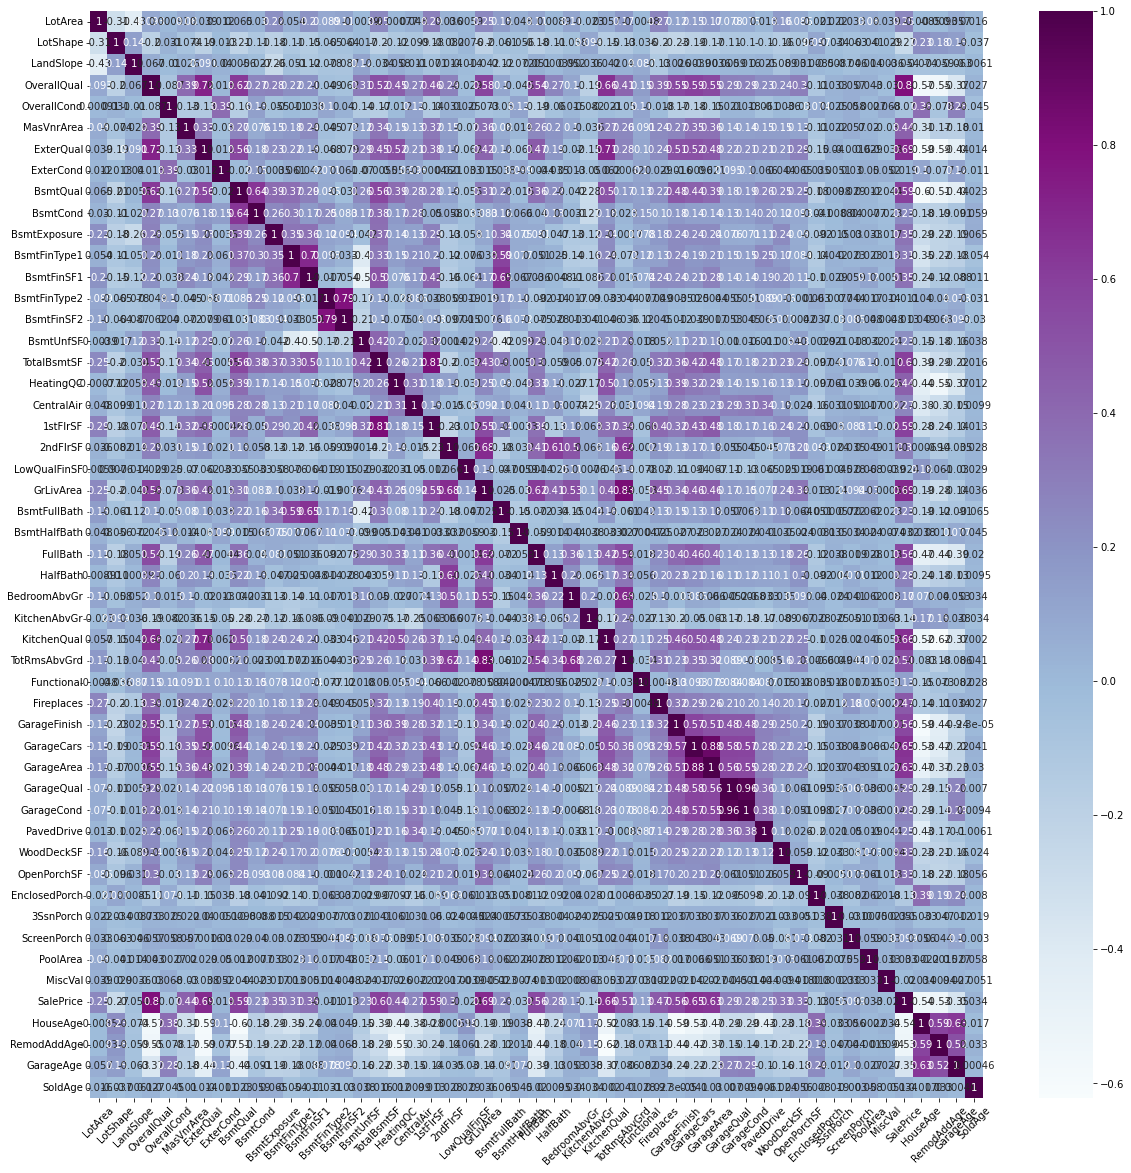

In [35]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='BuPu', annot=True)
plt.xticks(rotation = 45)
plt.show()

As can be seen from the heatmap:
- The 'SalePrice' is highly correlated with several features including 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageCars', and 'GarageArea'.
- There are high correlations of more than 0.50 between some of the features, e.g. between 'TotRmsAbvGrd' and '2ndFlrSF', 'GrLivArea', 'FullBath', and 'BedroomAbvGr'. However, let RFE selects the most important features.  
  
  
  
Below, the list of the numeric and categorical columns are extracted. Then, it was checked for the categorical columns that no numeric value is saved as a string (object) in those columns. No problems were detected in that respect, and hence all our categorical columns are genuinely categorical.

In [36]:
# extracting the initial numeric and categorical columns list
num_cols = [element for element in list(df.describe().columns)]
cat_cols = [element for element in list(df.columns) if (element not in num_cols)]

# Step 2: Data Preparation for Building Model

In [37]:
n_col_b4_dummy = df.shape[1]
print('shape of df before dummary variables implementation: ', df.shape)
for col in cat_cols:
    df = cat_col_to_dummy(df, col)

n_col_after_dummy = df.shape[1]
print('shape of df after dummary variables implementation: ', df.shape)
print('A total of {} new columns added due to dummary variables implementation.'.format(n_col_after_dummy - n_col_b4_dummy))

shape of df before dummary variables implementation:  (1442, 73)
shape of df after dummary variables implementation:  (1442, 205)
A total of 132 new columns added due to dummary variables implementation.


In [38]:
df_train, df_test = train_test_split(df, train_size = 0.8, random_state =  0)

In [39]:
# Scaling all the columns including the target column, i.e. SalePrice
scaler = StandardScaler()

df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

In [40]:
df_train.describe()

,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
count,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,1.153000e+03,...,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000
mean,5.676292e-17,4.878048e-16,-1.760662e-16,2.347549e-16,1.366354e-16,-1.972981e-16,1.583007e-16,1.777512e-16,1.887283e-16,1.192792e-16,...,0.003469,0.003469,0.081526,0.001735,0.871639,0.000867,0.007806,0.013877,0.823938,0.083261
std,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,1.000434e+00,...,0.058823,0.058823,0.273761,0.041631,0.334636,0.029450,0.088043,0.117031,0.381039,0.276396
min,-1.032328e+00,-4.495238e+00,-6.995224e+00,-3.811518e+00,-4.120985e+00,-5.821414e-01,-2.443978e+00,-5.897821e+00,-4.070198e+00,-5.519653e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.096920e-01,-1.019041e+00,2.286840e-01,-8.153154e-01,-5.302079e-01,-5.821414e-01,-6.915485e-01,-2.286358e-01,-5.680052e-01,1.190002e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-9.086903e-02,7.190572e-01,2.286840e-01,-6.626468e-02,-5.302079e-01,-5.821414e-01,-6.915485e-01,-2.286358e-01,-5.680052e-01,1.190002e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.426192e-01,7.190572e-01,2.286840e-01,6.827860e-01,3.674862e-01,3.592881e-01,1.060881e+00,-2.286358e-01,5.993923e-01,1.190002e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.367273e+01,7.190572e-01,2.286840e-01,2.929938e+00,3.060569e+00,6.231153e+00,2.813310e+00,5.440550e+00,1.766790e+00,1.998551e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
df_test.describe()

,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,...,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,0.111366,0.063511,0.016216,-0.055897,-0.036321,0.124432,-0.091235,0.045996,-0.054997,-0.030583,...,0.003460,0.003460,0.072664,0.003460,0.868512,0.010381,0.006920,0.013841,0.826990,0.076125
std,1.600838,1.053911,0.998291,1.091870,1.008551,1.221500,0.941260,0.992209,1.090245,1.198851,...,0.058824,0.058824,0.260035,0.058824,0.338519,0.101531,0.083044,0.117033,0.378912,0.265657
min,-1.011889,-4.495238,-6.995224,-3.062467,-3.223290,-0.582141,-2.443978,-3.063229,-4.070198,-5.519653,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.328052,-1.019041,0.228684,-0.815315,-0.530208,-0.582141,-0.691548,-0.228636,-0.568005,0.119000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-0.096989,0.719057,0.228684,-0.066265,-0.530208,-0.582141,-0.691548,-0.228636,0.599392,0.119000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.162019,0.719057,0.228684,0.682786,0.367486,0.600680,1.060881,-0.228636,0.599392,0.119000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,17.831486,0.719057,0.228684,2.929938,3.060569,9.073546,2.813310,5.440550,1.766790,1.998551,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
y_train = df_train.pop(target_col)
x_train = df_train

y_test = df_test.pop(target_col)
x_test = df_test

# Step 3: Model Building and Training

In [43]:
# using RFE to select most important features, in this case 40

lrm = LinearRegression()
lrm.fit(x_train, y_train)
rfe = RFE(lrm, 40)
rfe.fit(x_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=40)

In [44]:
rfe_sel_cols =[x_train.columns[i] for i in range(len(x_train.columns)) if rfe.support_[i] == True]
rfe_sel_cols

['OverallQual',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
 'DUPLEX - ALL STYLES AND AGES',
 'FV',
 'RH',
 'RL',
 'RM',
 'NoRidge',
 'NridgHt',
 'StoneBr',
 'Veenker',
 'RRAe',
 'PosN',
 'Duplex',
 '2.5Fin',
 'CompShg',
 'Membran',
 'Metal',
 'Roll',
 'Tar&Grv',
 'WdShake',
 'WdShngl',
 'CBlock',
 'CemntBd',
 'ImStucc',
 'CBlock',
 'CmentBd',
 'Other',
 'Wood',
 'GasW',
 'Grav',
 'OthW',
 'Wall',
 'CWD',
 'New',
 'Alloca']

In [45]:
x_train = x_train[rfe_sel_cols]
x_test = x_test[rfe_sel_cols]

### Base Regression model

In [46]:
lrm_base = LinearRegression()
lrm_base.fit(x_train, y_train)
y_train_pred = lrm_base.predict(x_train)
y_test_pred = lrm_base.predict(x_test)
r2_train_base = r2_score(y_true = y_train, y_pred = y_train_pred)
r2_test_base = r2_score(y_true = y_test, y_pred = y_test_pred)

print('R2 score (Base model) on train set: ', r2_train_base)
print('R2 score (Base model) on test set: ', r2_test_base)

R2 score (Base model) on train set:  0.8686589203604953
R2 score (Base model) on test set:  0.7859859590437873


### Ridge Regression

In [47]:
lambda_list = [10.**i for i in range(10)]

r2_score_train = []
r2_score_test = []

for lambda_value in lambda_list:
    lrm = Ridge(alpha = lambda_value)
    lrm.fit(x_train, y_train)
    y_train_pred = lrm.predict(x_train)
    y_test_pred  = lrm.predict(x_test)
    r2_score_train.append(r2_score(y_true = y_train, y_pred = y_train_pred))
    r2_score_test.append(r2_score(y_true = y_test, y_pred = y_test_pred))

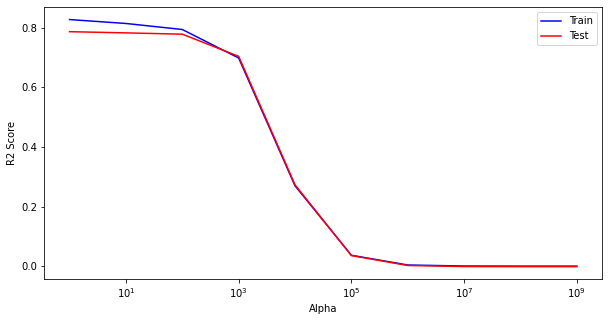

In [48]:
plt.figure(figsize=(10,5))
plt.plot(lambda_list, r2_score_train, color = 'b', label = 'Train')
plt.plot(lambda_list, r2_score_test, color = 'r', label = 'Test')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [49]:
ridge_df = pd.DataFrame(list(zip(lambda_list, r2_score_train, r2_score_test)), 
                        columns = ['Lambda', 'R2 train', 'R2 test'])
ridge_df

,Lambda,R2 train,R2 test
0,1.000000e+00,0.827461,0.786802
1,1.000000e+01,0.814300,0.782726
2,1.000000e+02,0.794098,0.778455
3,1.000000e+03,0.698468,0.704066
4,1.000000e+04,0.269495,0.272909
5,1.000000e+05,0.036501,0.035426
6,1.000000e+06,0.003781,0.002115
7,1.000000e+07,0.000379,-0.001347
8,1.000000e+08,0.000038,-0.001695
9,1.000000e+09,0.000004,-0.001729


I would choose $Lambda = 1000$ as the best value for lambda, since the values of $R^2$ score of train and test are close. Increasing $Lambda$ beyond this value, although gives similar values of $R^2$ score of train and test, however, the $R^2$ score values are really low and the model is under-fit.

In [50]:
best_lambda = 1000.0
lrm_ridge = Ridge(alpha = best_lambda)
lrm_ridge.fit(x_train, y_train)
y_train_pred = lrm_ridge.predict(x_train)
y_test_pred  = lrm_ridge.predict(x_test)
r2_train_ridge = r2_score(y_true = y_train, y_pred = y_train_pred)
r2_test_ridge = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R2 score (Ridge model) on train set: ', r2_train_ridge)
print('R2 score (Ridge model) on test set: ', r2_test_ridge)

R2 score (Ridge model) on train set:  0.6984680085312021
R2 score (Ridge model) on test set:  0.7040657779901407


In [51]:
lrm_df = pd.DataFrame(list(zip(x_train.columns, lrm_ridge.coef_)), columns = ['Feature', 'Coefficient'])
lrm_df=lrm_df.reindex(lrm_df['Coefficient'].abs().sort_values(ascending = False).index)
lrm_df.head(5)

,Feature,Coefficient
0,OverallQual,0.293827
3,1stFlrSF,0.169078
4,2ndFlrSF,0.147993
2,TotalBsmtSF,0.143683
1,BsmtFinSF1,0.089075


It can be seen that the Ridge model has identified the following variables as the most significant ones:
- OverallQual (rating of the overall material and finish of the house)
- 1stFlrSF (First floor surface area in square feet)
- 2ndFlrSF (Second floor surface area in square feet)
- TotalBsmtSF (Total basement floor surface area in square feet)
- BsmtFinSF1 (Type 1 finished in square feet)
  
### Lasso Regression

In [52]:
lambda_list = [10.0 ** i for i in range(-3,3)]

r2_score_train = []
r2_score_test = []

for lambda_value in lambda_list:
    lrm = Lasso(alpha = lambda_value)
    lrm.fit(x_train, y_train)
    y_train_pred = lrm.predict(x_train)
    y_test_pred  = lrm.predict(x_test)
    r2_score_train.append(r2_score(y_true = y_train, y_pred = y_train_pred))
    r2_score_test.append(r2_score(y_true = y_test, y_pred = y_test_pred))

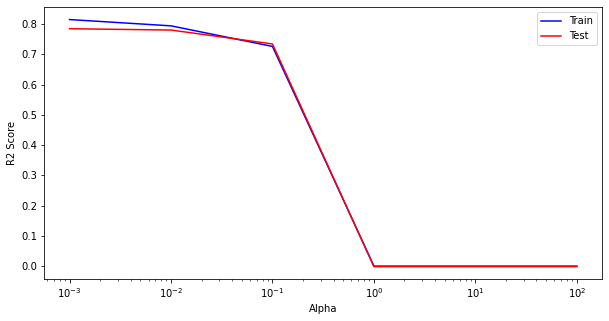

In [53]:
plt.figure(figsize=(10,5))
plt.plot(lambda_list, r2_score_train, color = 'b', label = 'Train')
plt.plot(lambda_list, r2_score_test, color = 'r', label = 'Test')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [54]:
lasso_df = pd.DataFrame(list(zip(lambda_list, r2_score_train, r2_score_test)), 
                        columns = ['Lambda', 'R2 train', 'R2 test'])
lasso_df

,Lambda,R2 train,R2 test
0,0.001,0.815584,0.785252
1,0.010,0.794777,0.780886
2,0.100,0.726642,0.734876
3,1.000,0.000000,-0.001733
4,10.000,0.000000,-0.001733
5,100.000,0.000000,-0.001733


I would choose $Lambda = 0.1$ as the best value for lambda, since the values of $R^2$ score of train and test are close. Increasing $Lambda$ beyond this value, although gives similar values of $R^2$ score of train and test, however, the $R^2$ score values are really low and the model is under-fit.

In [55]:
best_lambda = 0.1
lrm_lasso = Lasso(alpha = best_lambda)
lrm_lasso.fit(x_train, y_train)
y_train_pred = lrm_lasso.predict(x_train)
y_test_pred  = lrm_lasso.predict(x_test)
r2_train_lasso = r2_score(y_true = y_train, y_pred = y_train_pred)
r2_test_lasso = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R2 score (Lasso model) on train set: ', r2_train_lasso)
print('R2 score (Lasso model) on est set: ', r2_test_lasso)

R2 score (Lasso model) on train set:  0.7266418231963927
R2 score (Lasso model) on est set:  0.7348759316524553


In [56]:
lrm_df = pd.DataFrame(list(zip(x_train.columns, lrm_lasso.coef_)), columns = ['Feature', 'Coefficient'])
lrm_df=lrm_df.reindex(lrm_df['Coefficient'].abs().sort_values(ascending = False).index)
lrm_df.head(5)

,Feature,Coefficient
0,OverallQual,0.545742
3,1stFlrSF,0.227597
4,2ndFlrSF,0.102673
1,BsmtFinSF1,0.042236
2,TotalBsmtSF,0.031533


It can be seen that the Lasso model has identified the following variables as the most important ones:
- OverallQual (rating of the overall material and finish of the house)
- 1stFlrSF (First floor surface area in square feet)
- 2ndFlrSF (Second floor surface area in square feet)
- BsmtFinSF1 (Type 1 finished in square feet)
- TotalBsmtSF (Total basement floor surface area in square feet)  

As can be seen, Lasso's 5 most significant features are exactly the same as the 5 most significant features of Ridge regressor, except the ranking of the last two are different.
  
  
# Step 4: Residual Analysis
  
### Ridge model residual analysis

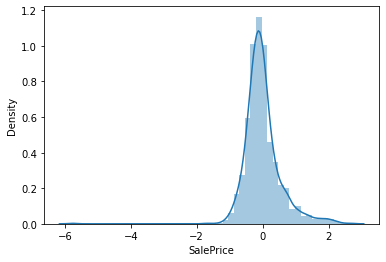

In [57]:
y_train_pred = lrm_ridge.predict(x_train)
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

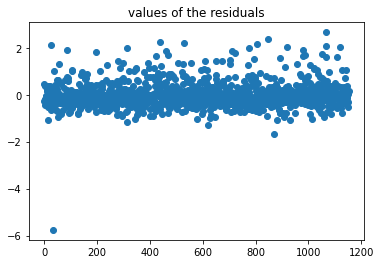

In [58]:
x_plt = np.array(list(range(len(res))))
plt.scatter(x_plt, res)
plt.title('values of the residuals')
plt.show()

### Lasso model residual analysis

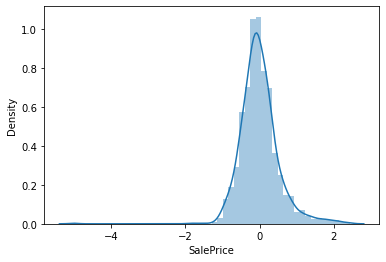

In [59]:
y_train_pred = lrm_lasso.predict(x_train)
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

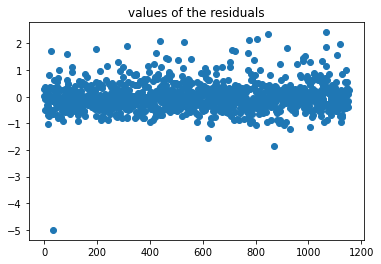

In [60]:
x_plt = np.array(list(range(len(res))))
plt.scatter(x_plt, res)
plt.title('values of the residuals')
plt.show()

Analysis of the histogram and the scatter plot of the residuals reveals that:

- the residuals follow a normal distribution with a mean of zero, as expected as one of the conditions of the MLR assumptions.
- the residuals are scattered around 0, and are independent of each other.
- the residuals have constant variance (homoscedasticity).
  
  
# Step 5: Summarising the Base, Ridge, and Lasso models, and Conclusion

In [61]:
r2_base = [r2_train_base, r2_test_base]
r2_ridge = [r2_train_ridge, r2_test_ridge]
r2_lasso = [r2_train_lasso, r2_test_lasso]
r2_df = pd.DataFrame(list(zip(r2_base, r2_ridge, r2_lasso)), columns = ['Base', 'Ridge', 'Lasso'], index = ['train set', 'test set'])
r2_df

,Base,Ridge,Lasso
train set,0.868659,0.698468,0.726642
test set,0.785986,0.704066,0.734876


In [62]:
lrm_lasso.coef_

array([ 0.54574164,  0.04223552,  0.03153277,  0.22759739,  0.10267332,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [63]:
lrm_ridge.coef_

array([ 2.93827048e-01,  8.90754677e-02,  1.43683110e-01,  1.69077724e-01,
        1.47992543e-01,  3.48551295e-04, -1.23370300e-02,  1.33105859e-02,
       -2.13463737e-03,  4.93280243e-02, -5.48859459e-02,  2.28122807e-02,
        4.61771475e-02,  9.15677598e-03,  2.27671475e-03, -3.86197330e-03,
       -3.72168874e-05,  3.51633647e-03,  9.70785196e-04, -1.23370300e-02,
       -9.99535970e-04,  2.08813903e-03,  7.07504659e-04,  2.39350310e-04,
       -2.94668748e-04,  1.39622822e-03,  9.16712028e-04,  7.08487110e-04,
       -4.65445734e-04, -4.65445734e-04, -6.19130022e-02,  1.79982972e-02,
        1.90195967e-04, -1.80875043e-03, -4.65445734e-04, -4.65445734e-04,
       -6.19130022e-02,  1.96209702e-02,  8.05297455e-04, -4.26416957e-04,
       -1.33732390e-03, -3.59103728e-03, -6.89667023e-04,  1.98570453e-05,
        7.44104346e-04,  5.21100643e-02,  1.40346479e-03])

As can be seen, by comparing the values of $R^2$ score of different models, the Lasso model is chosen due to the following reasons:
- The higher $R^2$ score compared to the Ridge model, and the lower difference between $R^2$ score of train and test in comparison to the base model. In other words, the $R^2$ score of the base model is higher than the Lasso, however, the difference between the $R^2$ score of train and test sets of the base model is higher than that of the Lasso model, which means the base model is slightly over-fit.
- The Lasso model has only 5 non-zero coefficients for the features, and while having a higher $R^2$ score compared to the Ridge, seems to be simpler and more generalisable.

## Answer to the Business Problem
Accordingly, the most significant variables (of the selected Lasso model) describing the price of a house, with an **$R^2$ score of around 73%** are:
- OverallQual (rating of the overall material and finish of the house)
- 1stFlrSF (First floor surface area in square feet)
- 2ndFlrSF (Second floor surface area in square feet)
- BsmtFinSF1 (Type 1 finished in square feet)
- TotalBsmtSF (Total basement floor surface area in square feet)  
  
  
# Acknowledgements
- I would like to acknowledge the feedback, support and dataset provision by [upGrad](https://www.upgrad.com/gb) and The [International Institute of Information Technology (IIIT), Bangalore](https://www.iiitb.ac.in/).  
- Also, I would like to express my gratitude to [Nishan Ali](https://www.linkedin.com/in/nishan-ali-826552166/) and Eshan Tiwari for providing clarification and guidance to carry out this project.   
- Furthermore, the valuable feedback from [Dr Tayeb Jamali](https://www.linkedin.com/in/tayeb-jamali-b1a10937/) is highly appreciated.